# Exercise 3 Part 1

In [2]:
import numpy
import math
from matplotlib import pyplot as plt
from scipy.special import expit as sigmoid
%matplotlib inline

We need to load the matrix files this time into numpy.  They are matlab format files but that's alright (http://docs.scipy.org/doc/scipy/reference/tutorial/io.html)

In [3]:
import scipy.io

loadedData = scipy.io.loadmat("ex3/ex3data1.mat")
print loadedData.keys()

['y', 'X', '__version__', '__header__', '__globals__']


It looks like we have 'X' and 'y' data variables, so let's make them into local variables for easier use:

In [49]:
x = loadedData['X']
y = loadedData['y'].flatten()

In [50]:
print "X shape is ", x.shape
print "Y shape is ", y.shape

X shape is  (5000, 400)
Y shape is  (5000,)


Let's add an additional x0 entry to each sample value to make sure we can properly include the bias term

In [115]:
x = numpy.insert(x,0,1,axis=1)
print x.shape

(5000, 401)


## Visualize the data

Each entry in X, an array of length 400, is actually a 20x20 digit image.  We can display them with imshow, to see what the data looks like:

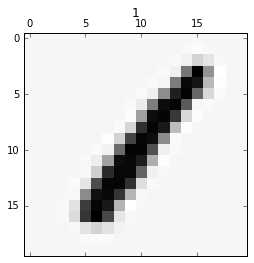

In [126]:
i = int(5000*numpy.random.rand())
image = x[i][1:]
# This reshapes the image into a 20x20 array for displaying:
image.shape=(20,20)
plt.matshow(image.T,cmap=plt.cm.gray_r)
plt.title(y[i])


That works nicely, so let's make a big 10x10 layout of images:

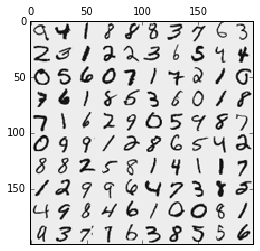

In [127]:
def getImage(index):
    image = x[index][1:]
    # This reshapes the image into a 20x20 array for displaying:
    image.shape=(20,20)
    return image

def makeLargeImage():
    # The final image is a big array of 100 images of 20x20 each.  That means it's 100*400 floats long:
    stride = 20
    master = numpy.zeros((10*stride, 10*stride))
    for i_x in xrange(10):
        for i_y in xrange(10):
            index = int(5000*numpy.random.rand())
            im = getImage(index)

            # This is probably the trickiest part: we have to insert the small image into the master image
            # But with numpy, it's not really so bad.  Check out this stack overflow reference:
            # http://stackoverflow.com/questions/7115437/how-to-embed-a-small-numpy-array-into-a-predefined-block-of-a-large-numpy-arra
            master[i_x*stride:i_x*stride+stride, i_y*stride:i_y*stride+stride] = im.T
    return master


master = makeLargeImage()
plt.matshow(master,cmap=plt.cm.gray_r)
# plt.title(y[i])

Working towards the cost function and gradient, let's verify that some of the necessary operations work:

In [128]:
theta = numpy.zeros(x.shape[1])
print x.shape
print theta.shape

print numpy.dot(x, theta).shape

(5000, 401)
(401,)
(5000,)


Define the cost function, first (including a regularization term):

In [258]:
# this definition assumes theta is length 1 + number of features, with theta[0] as the bias term.
# x is (m number of examples) x (n number of features), so it is a 2D mxn array

def h(theta, x):
    # This function should return a vector of length m, equal to the number of examples
    # This operation does the inner product of all of the x entries with all of the theta values:
    return sigmoid(numpy.dot(x, theta))
    

def cost(theta,x,y,l=0):
    # Get the number of entries (should be 5000)
    _m = y.shape[0]
    # Compute h just once, returns a vector of shape (5000)
    _h = h(theta,x)

    # The cost function is a scalar, so this function returns a single value.
    _cost = - numpy.dot(y,numpy.log(_h)) / _m
    _cost += - numpy.dot(1 - y, numpy.log(1 - _h)) / _m
    # Need to include the regularization term too:
    if l != 0:
        reg = l*numpy.dot(theta[1:],theta[1:]) / (2*_m)
        return _cost + reg
    else:
        return _cost
    
    
def gradient(theta,x,y,l=0):
    _h = h(theta,x)
    _m = y.shape[0]
    
    # The gradient should be equal to the length of the vector of theta (n features + 1)
    grad = numpy.dot(_h - y, x) / _m + l*theta / _m 
    if l != 0:
        correction = l*theta[0] / _m
#         print correction
        grad[0] -= l*theta[0] / _m
    return  grad



Let's test things out by making just one classifier to start, to verify things work:

In [216]:
theta_3 = numpy.zeros(x.shape[1])
iterations = 200
min_iterations = 10
alpha = 1.0
l = 0.2
cost_gradient_limit = 0.001

# To actually train, we need to select one class as "correct" and set all the rest to "incorrect":
y_3 = numpy.copy(y)
d= {10:0, 1:0, 2:0,3:1,4:0,5:0,6:0,7:0,8:0,9:0}
for k, v in d.iteritems(): y_3[y==k] = v

print "Initial Cost: {}".format(cost(theta_3,x,y_3,l))
    
cost_history = []

for i in xrange(iterations):
    # Update the theta parameters:
    grad = gradient(theta_3,x,y_3,l)
    theta_3 -= alpha*grad
    cost_history.append(cost(theta_3,x,y_3,l))
    if len(cost_history) > min_iterations:
        _cost_diff = (cost_history[-2] - cost_history[-1]) / cost_history[-2]
        if _cost_diff < cost_gradient_limit:
            print "Ending early after {} iterations".format(i)
            break
#     print cost_history[-1]

print "Final Cost: {}".format(cost(theta_3,x,y_3,l))


Initial Cost: 0.69314718056
Ending early after 156 iterations
Final Cost: 0.0917898644937


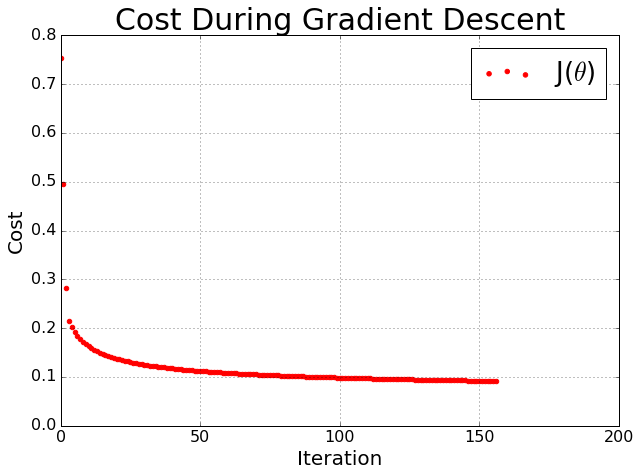

In [217]:
def plotCost(x,y):
    
    #Define the plot
    fig, ax = plt.subplots(figsize=(10,7))
    
    #Plot the data
    #I have to use a raw string (with the r in front) to render the theta correctly
    plt.scatter(x,y,marker="o",color='r',label=r"J($\theta$)")
    

    # Plots require a title and axis labels:
    plt.title("Cost During Gradient Descent", fontsize=30)
    plt.xlabel("Iteration", fontsize=20)
    plt.ylabel("Cost", fontsize=20)

    # Make the ticks bigger to be more visible:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    
    # Set the plot limits
    ax.set_xlim(0,iterations)

    # Always, plt.grid(True)
    plt.grid(True)
    plt.legend(fontsize=26)

it = range(len(cost_history))

plotCost(it,cost_history)

Test it by seeing if it actually can find the number 3, and reject others:

In [251]:
print "Prediction for 0 is {}".format(h(theta_3,x[100]))
print "Prediction for 1 is {}".format(h(theta_3,x[600]))
print "Prediction for 2 is {}".format(h(theta_3,x[1100]))
print "Prediction for 3 is {}".format(h(theta_3,x[1600]))
print "Prediction for 4 is {}".format(h(theta_3,x[2100]))
print "Prediction for 5 is {}".format(h(theta_3,x[2600]))
print "Prediction for 6 is {}".format(h(theta_3,x[3100]))
print "Prediction for 7 is {}".format(h(theta_3,x[3600]))
print "Prediction for 8 is {}".format(h(theta_3,x[4100]))
print "Prediction for 9 is {}".format(h(theta_3,x[4600]))

Prediction for 0 is 0.0104124834841
Prediction for 1 is 0.00886128307097
Prediction for 2 is 0.000307993890604
Prediction for 3 is 0.955096124091
Prediction for 4 is 7.22780921363e-05
Prediction for 5 is 0.000562358183963
Prediction for 6 is 0.00154479536484
Prediction for 7 is 0.000814814590096
Prediction for 8 is 0.0754289036912
Prediction for 9 is 0.000614610572672


Ok, that's at least promising.  It's pretty cool that the second choice for '3' is '8' - numbers that visually look pretty similar.

In [274]:
#this function trains a classifier for a integer
def train_theta(i,verbose=False):
    # First, we need to define y properly for this value:
    d = dict()
    for _i in xrange(10):
        d.update({_i+1:0})
    if i == 0:
        d[10] = 1
    else:
        d[i] = 1
    _this_y = numpy.copy(y)
    for k, v in d.iteritems(): _this_y[y==k] = v

    # Next, initialize theta:
    _this_theta = numpy.zeros(x.shape[1])
    
    if verbose: print "Initial Cost is {}".format(cost(_this_theta,x,_this_y))
    l =0.2
    alpha = 0.5
    min_iterations = 20
    max_iterations = 300
    cost_history = []
    # If the difference in cost between a step and the previous step is less than this limit, stop training
    cost_gradient_limit = 0.0001

    for i in xrange(max_iterations):
        # Update the theta parameters:
        grad = gradient(_this_theta,x,_this_y,l)
        _this_theta -= alpha*grad
        cost_history.append(cost(_this_theta,x,_this_y,l))
        if len(cost_history) > min_iterations:
            _cost_diff = (cost_history[-2] - cost_history[-1]) / cost_history[-2]
            if _cost_diff < cost_gradient_limit:
                if verbose: print "Ending early after {} iterations".format(i)
                break
    if verbose: print "Final Cost is {}".format(cost(_this_theta,x,_this_y))
    return _this_theta


In [275]:
def train_prediction():
    
    # This function builds a classifier for each number, 0 to 9
    
    # This is where each theta will be stored:
    
    theta_map = []
    
    for i in range(0,10):
#         _this_theta = []
        _this_theta = train_theta(i,verbose=False)
        theta_map.append(_this_theta)
        
    return theta_map

def predict(image):
    # This function classifies the image
    score = []
    for i in range(0,10):
        score.append(h(theta_map[i],image))
    
    # find the location of max value:
    return score.index(numpy.max(score))


theta_map = train_prediction()

Now, loop through every image and classify it.  Measure the accuracy over the whole data set.

In [276]:
n_correct = 0
n_incorrect = 0

for image, answer in zip(x,y):
#     print image.shape
    prediction = predict(image)
    if answer == 10:
        answer = 0
    if answer == prediction:
        n_correct += 1
    else:
        n_incorrect += 1

print n_correct
print n_incorrect

print "Total accuracy of this classifier is {:.3}%".format(100.*n_correct/(n_correct + n_incorrect))

4530
470
Total accuracy of this classifier is 90.6%
